# MNIST Classifier

### Load modules

In [1]:
import tensorflow as tf
import numpy as np
import sys
import os

from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook

%matplotlib inline

### Load data

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
x_train = mnist.train.images
y_train = mnist.train.labels
x_test = mnist.test.images
y_test = mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Plot number

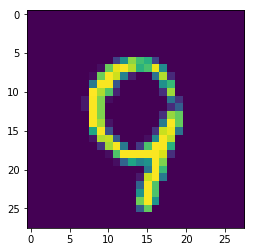

In [3]:
n_train = np.shape(x_train)[0]
idx = np.random.randint(n_train)
vector = x_train[idx]
img = np.reshape(vector, (28, 28))

plt.imshow(img)

### TensorBoard summaries

In [4]:
# remove summaries
def clean_folder(path="tensorflow_summaries/"):
    for file in os.listdir(path):
        filepath = path + file
        if os.path.isfile(filepath):
            os.remove(filepath)
        
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

### MLP architecture

In [7]:
# reset graph (important for batch normalization and summary)
tf.reset_default_graph()

# placeholder
x_input = tf.placeholder(tf.float32, [None, 784])
y_input = tf.placeholder(tf.float32, [None, 10])

with tf.device("/cpu:0"):
    
        
    with tf.name_scope("W"):
        W = tf.Variable(tf.zeros([784, 10]), name='weights')
        variable_summaries(W)

    with tf.name_scope('b'):
        b = tf.Variable(tf.zeros([10]), name='biases')
        variable_summaries(b)
            
    with tf.name_scope("xw_plus_b"):
        preds = tf.matmul(x_input, W) + b
        tf.summary.histogram('preds', preds)

    with tf.name_scope("cross_entropy"):
        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                labels=y_input, 
                logits=preds
            )
        )
        tf.summary.scalar('cross_entropy', cross_entropy)
        
    with tf.name_scope("optimization"):
        train_step = tf.train.AdamOptimizer().minimize(cross_entropy)
        
    with tf.name_scope("accuracy"):
        correct_prediction = tf.equal(tf.argmax(preds, axis=1), tf.argmax(y_input, axis=1)) 
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('accuracy', accuracy)
        
    merged = tf.summary.merge_all()
    init = tf.global_variables_initializer()
    
# feed dict helper
def feed_dict(train=True):
    if train:
        xs, ys = mnist.train.next_batch(100)
    else:
        xs, ys = mnist.test.images, mnist.test.labels
    return {x_input: xs, y_input: ys}

### Test graph architecture

In [8]:
with tf.Session() as sess:
    sess.run(init)
    __ = sess.run(merged, feed_dict=feed_dict(False))

### Clean summaries folder

In [9]:
clean_folder(path="./tensorflow_summaries/train")
clean_folder(path="./tensorflow_summaries/test")

### Train model

In [10]:

# using graph for training
with tf.Session() as sess:
    sess.run(init)
    train_writer = tf.summary.FileWriter("./tensorflow_summaries/train", sess.graph)
    test_writer = tf.summary.FileWriter("./tensorflow_summaries/test")
    
    for i in range(1000):
        if i % 10 == 0:
            summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict(False))
            test_writer.add_summary(summary, i)
            if i % 100 == 0:
                print('Acc at epoch %s: %s' % (i, acc))
        else:
            summary, __ = sess.run([merged, train_step], feed_dict=feed_dict(True))
            train_writer.add_summary(summary, i)
    # test
    out = sess.run(accuracy, feed_dict=feed_dict(False))
    print("Acc. on test: %f" % out)

Acc at epoch 0: 0.098
Acc at epoch 100: 0.8436
Acc at epoch 200: 0.8747
Acc at epoch 300: 0.8859
Acc at epoch 400: 0.8966
Acc at epoch 500: 0.8983
Acc at epoch 600: 0.9026
Acc at epoch 700: 0.9067
Acc at epoch 800: 0.9085
Acc at epoch 900: 0.913
Acc. on test: 0.912500
